# Aufgabe 1

Implementieren Sie den asymptotisch korrekter Fehlerschätzer (aus Folgerung 1.40) für die Simp-
sonregel. Implementieren Sie weiters die Richardson-Extrapolation der Simpsonregel und bestimmen
Sie die Ordnung dieses neuen Quadraturverfahrens aus einem Genauigkeits-Aufwandsdiagramm.
Verwenden Sie zum Test das Integral von Aufgabe (1) auf Blatt 2.


In [1]:
# Importing Stuff

import numpy as np
from numpy.polynomial.legendre import leggauss
import matplotlib.pyplot as plt

Um diese Richardson Extrapolation durchzuführen muss man also $I_1$ und $I_2$ berechnen es gilt

$I_1 := h \sum_{i=1}^sb_if(\alpha + c_i h)$

$I_2 := \frac{h_2}\sum_{i=1}^{s}b_if(\alpha + c_i\frac{h}{2}) + \frac{h}{2}\sum_{i=1}^{s}b_if(\alpha + \frac{h}{2}+ c_i\frac{h}{2})$

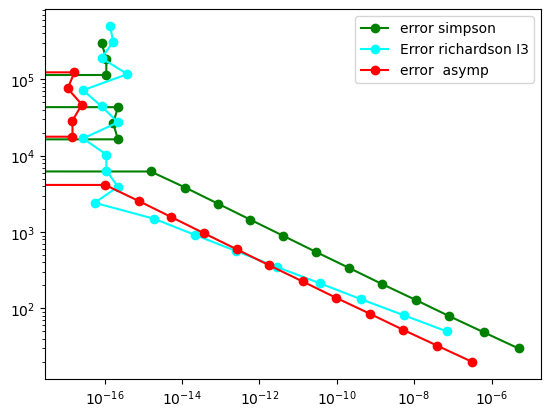

In [2]:
# First of all we implement our normal simpson rule 

def simpsonregel(f,a,b,N):
    x_vals = np.linspace(a,b,N)
    bi = [1/6, 2/3, 1/6]
    ci = [0, 1/2, 1]
    h_vals = np.diff(x_vals)
    interval_result = []
    for j in range(0,N-1):
        first_sum = []
        for i in range(0,3):
            result= bi[i] * f(x_vals[j]+ci[i]*h_vals[j])
            first_sum.append(result)
        interval_result.append((h_vals[j]*np.sum(first_sum)))
        
        #interval_result.append(result)
    return np.sum(interval_result)


# now we implement the richardson extrapolation

def richardson_extrapolation(quad_func,f, a,b, N):
    """
    Function that performes the Richardson extrapolation for a given quadrature formula

    Attributes:
        quad_func: function
            a quadrature function (e.q simpson, trapez ...)
        f: function
            the function we want to integrate
        a: int
            lower limit of integration
        b: int
            upper limit of integration
        N: int
            step size for calculation
    """
    # We calculate first with the stepsize N
    I1 = quad_func(f,a,b,N)

    # Now basically perform the calulation with double step size
    I2 = quad_func(f,a,b,2*N)

    # hardcode because order of simpson is 4
    p = 4

    asymp_error = (I2 - I1)/ (2**p -1)
    I3 = (2**p*I2 - I1)/(2**p - 1)

    return I1,I2,asymp_error,I3


        
def f(x):
    return np.cos(x)*np.exp(np.sin(x))


analytical_int = np.exp(np.sin(3)) -1

n = np.logspace(1,5,20)

error_simpson = np.empty(len(n))
error_I3 = np.empty(len(n))
error_asymp = np.empty(len(n))

for i in range(0,len(n)):
    error_simpson[i] = abs(simpsonregel(f,0,3,int(n[i]))-analytical_int)
    _ , _, asymp_err, I3 = richardson_extrapolation(simpsonregel,f,0,3,int(n[i]))
    error_I3[i] = abs(I3 - analytical_int)
    error_asymp[i] = asymp_err

plt.plot(error_simpson, 3*n, "-o",color="green", label="error simpson")
plt.plot(error_I3, 5*n, "-o",color="cyan", label="Error richardson I3")
plt.plot(error_asymp, 2*n, "-o",color="red", label="error  asymp")
plt.xscale("log")
plt.yscale("log")
plt.legend()
plt.show()



# Aufgabe 2

Implementieren Sie für die Trapezregel die Wahl der Gitterpunkte aus Abschnitt 1.6(i) und testen
Sie Ihre Implementierung am Beispiel

$\int_0^1 \frac{dx}{10^{-4} + x^2}$



Also Algorithmus

1. Wendet Quadratur auf [a,b] an wenn |Fehler| ≤ Tol fertig sonst halbieren
2. Dann wird auf jedes neue Teilintervall angewand und Fehler geschätzt
   1. Wenn |Fehler| ≤ TOl fertig
   2. Sonst das Interval mit größten Fehler weiter Halbieren

Ich persönlich verwende jetzt hier das Einbettungsverfahren um den Fehler zu Schätzen

Für das Einbettungsverfahren 

Result Trapezrule with N = 100 156.70561273236515
Interval Selector with tol = 0.0001; number of intervals 285
Interval Selector with tol = 0.00001; number of intervals 606


<function matplotlib.pyplot.show(close=None, block=None)>

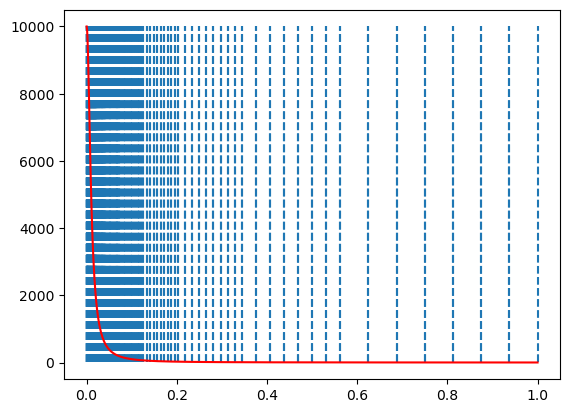

In [3]:

# Define the Trapezoidal Rule

def trapez_rule(f,a,b,N):
    x_vals = np.linspace(a,b,N)
    bi = [1/2,1/2]
    ci = [0,1]
    h_vals = np.diff(x_vals)
    interval_result = []
    for j in range(0,N-1):
        first_sum = []
        for i in range(0,2):
            result= bi[i] * f(x_vals[j]+ci[i]*h_vals[j])
            first_sum.append(result)
        interval_result.append((h_vals[j]*np.sum(first_sum)))
    return np.sum(interval_result)

def f(x):
    return 1/(10**(-4)+x**2)

print("Result Trapezrule with N = 100", trapez_rule(f,0,1,100))


# now define this embedding procedure for this quadrature
# Basically im using Simpson Rule for a Approximation of the trapezoidal rule

def error_embedding(f,a,b,N):
    """
    Calculates the Error based on the Embedding scheme of the script

    f: function
        function we want to integrate
    a: int
        start of integration
    b: int
        end of integration
    N: int
        stepsize
    """
    A1 = trapez_rule(f,a,b,N)
    A2 = simpsonregel(f,a,b,N)
    return (abs(A2-A1))



# With all this work we are now good to go to implement this interval selector

def interval_selector(lower_bound,upper_bound,f,tol):
    """
    The "Wahl der Gitterpunkte" Algorithm for the trapezoidal rule

    Attributes:
        lower_bound: int
            start interval
        upper_bound: int
            end interval
        f: function
            function we wwant to integrate
        tol: float
            a given tolerance
    """

    # the intervals are stored as tuples in a list
    intervals = [(lower_bound,upper_bound)]
    selection_result = []

    # now we basically do a while loop
    while len(intervals) != 0:
        (a,b) = intervals[0]
        
        # iterativley remove intervals after they have the right tolerance
        intervals.remove(intervals[0])
        # now calculate the embedding error wer we do a linspace with 2 
        if error_embedding(f,a,b,2) <= tol:
            # if this is the case we are done and can append the interval to our result
            selection_result.append((a,b))
        else:
            # now we calculate the halfwaypoint using the distance
            distance = b-a
            intervals.extend([(a,a+distance/2),(a+distance/2,b)])
    return selection_result

# Ok lets calculate some stuff

print("Interval Selector with tol = 0.0001; number of intervals", len(interval_selector(0,1,f,0.0001)) )
print("Interval Selector with tol = 0.00001; number of intervals", len(interval_selector(0,1,f,0.00001)))


# We can also plot the function

tolerance = 0.001

intervals_for_vis = interval_selector(0,1,f,tolerance)



x_vals = np.linspace(0,1, 1000)
y_vals = f(x_vals)

plt.vlines(intervals_for_vis,min(y_vals),max(y_vals),linestyles="dashed")
plt.plot(x_vals,y_vals,color="red")
plt.show